# ESIEE Paris — Data Engineering I — Assignment 3
> Author : Badr TAJINI

**Academic year:** 2025–2026  
**Program:** Data & Applications - Engineering - (FD)   
**Course:** Data Engineering I  

---

## Learning goals
- Analyze with **SQL** and **DataFrames**.
- Implement two **RDD means** variants.
- Implement **RDD joins** (shuffle and hash).
- Record and explain performance observations.


## 1. Setup

Download data files from the following URL:
https://www.dropbox.com/scl/fi/7012u693u06dgj95mgq2a/retail_dw_20250826.tar.gz?rlkey=fxyozuoryn951gzwmli5xi2zd&dl=0

Unpack somewhere and define the `data_path` accordingly:

In [3]:
# Change to path on your local machine.
data_path = "/mnt/c/Users/rania/OneDrive/Documents/ASS3/retail_dw_20250826"

The following cell contains setup to measure wall clock time and memory usage. (Don't worry about the details, just run the cell)

In [4]:
!pip install -U numpy pandas pyarrow matplotlib scipy
import sys, subprocess
try:
    import psutil  # noqa: F401
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "psutil"])
print("psutil is installed.")


from IPython.core.magic import register_cell_magic
import time, os, platform

# Try to import optional modules
try:
    import psutil
except Exception:
    psutil = None

try:
    import resource  # not available on Windows
except Exception:
    resource = None


def _rss_bytes():
    """Resident Set Size in bytes (cross-platform via psutil if available)."""
    if psutil is not None:
        return psutil.Process(os.getpid()).memory_info().rss
    # Fallback: unknown RSS → 0 
    return 0


def _peak_bytes():
    """
    Best-effort peak memory in bytes.
    - Windows: psutil peak working set (peak_wset)
    - Linux:   resource.ru_maxrss (KB → bytes)
    - macOS:   resource.ru_maxrss (bytes)
    Fallback to current RSS if unavailable.
    """
    sysname = platform.system()

    # Windows path: use psutil peak_wset if present
    if sysname == "Windows" and psutil is not None:
        mi = psutil.Process(os.getpid()).memory_info()
        peak = getattr(mi, "peak_wset", None)  # should be available on Windows
        if peak is not None:
            return int(peak)
        return int(mi.rss)

    # POSIX path: resource may be available
    if resource is not None:
        try:
            ru = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
            # On Linux ru_maxrss is in kilobytes; on macOS/BSD it is bytes
            if sysname == "Linux":
                return int(ru) * 1024
            else:
                return int(ru)
        except Exception:
            pass

    # Last resort
    return _rss_bytes()


@register_cell_magic
def timemem(line, cell):
    """
    Measure wall time and memory around the execution of this cell.

        %%timemem
        <your code>

    Notes:
    - RSS = resident memory after the cell.
    - Peak is OS-dependent (see _peak_bytes docstring).
    """
    ip = get_ipython()

    rss_before  = _rss_bytes()
    peak_before = _peak_bytes()
    t0 = time.perf_counter()

    # Execute the cell body
    result = ip.run_cell(cell)

    t1 = time.perf_counter()
    rss_after  = _rss_bytes()
    peak_after = _peak_bytes()

    wall = t1 - t0
    rss_delta_mb  = (rss_after  - rss_before)  / (1024 * 1024)
    peak_delta_mb = (peak_after - peak_before) / (1024 * 1024)

    print("======================================")
    print(f"Wall time: {wall:.3f} s")
    print(f"RSS Δ: {rss_delta_mb:+.2f} MB")
    print(f"Peak memory Δ: {peak_delta_mb:+.2f} MB (OS-dependent)")
    print("======================================")

    return result

psutil is installed.


The following code snippet should "just work" to initialize Spark.

In [5]:
import findspark, os

# Change to path on your local machine.
os.environ["SPARK_HOME"] = "/home/ranajabry/miniconda3/lib/python3.13/site-packages/pyspark"
findspark.init()


from pyspark.sql import SparkSession, functions as F, Window
from pyspark.sql.functions import broadcast

py = sys.executable  # the Python of this notebook (e.g., .../envs/yourenv/bin/python)
os.environ["PYSPARK_DRIVER_PYTHON"] = py
os.environ["PYSPARK_PYTHON"] = py

spark = SparkSession.getActiveSession() or (
    SparkSession.builder
    .appName("A3")
    .master("local[*]")
    .config("spark.driver.memory", "8g")           
    .config("spark.sql.shuffle.partitions","400")
    .config("spark.sql.adaptive.enabled", "true")
    .config("spark.pyspark.driver.python", py)
    .config("spark.pyspark.python", py)
    .config("spark.executorEnv.PYSPARK_PYTHON", py)
    .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")

sc = spark.sparkContext
print("Spark:", spark.version)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/30 20:32:29 WARN Utils: Your hostname, Rana, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/12/30 20:32:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/30 20:32:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark: 4.0.1


## 2. Loading DataFrames

In [6]:
data_path = "/mnt/c/Users/rania/OneDrive/Documents/ASS3/retail_dw_20250826"

Let's load the DataFrames and print out their schemas:

In [7]:
# Note that you should have defined data_path above

events_df   = spark.read.parquet(os.path.join(data_path, "retail_dw_20250826_events"))
products_df = spark.read.parquet(os.path.join(data_path, "retail_dw_20250826_products"))
brands_df   = spark.read.parquet(os.path.join(data_path, "retail_dw_20250826_brands"))

events_df.printSchema()
products_df.printSchema()
brands_df.printSchema()

root
 |-- date_key: integer (nullable = true)
 |-- user_key: integer (nullable = true)
 |-- age_key: integer (nullable = true)
 |-- product_key: integer (nullable = true)
 |-- brand_key: integer (nullable = true)
 |-- category_key: integer (nullable = true)
 |-- session_id: string (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- price: double (nullable = true)

root
 |-- category_code: string (nullable = true)
 |-- brand_code: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- product_desc: string (nullable = true)
 |-- brand_key: integer (nullable = true)
 |-- category_key: integer (nullable = true)
 |-- product_key: integer (nullable = true)

root
 |-- brand_code: string (nullable = true)
 |-- brand_desc: string (nullable = true)
 |-- brand_key: integer (nullable = true)



How many rows are in each table?

In [8]:
print(f"Number of rows in events   table: {events_df.count()}")
print(f"Number of rows in products table: {products_df.count()}")
print(f"Number of rows in brands   table: {brands_df.count()}")

Number of rows in events   table: 42351862
Number of rows in products table: 166794
Number of rows in brands   table: 3444


We can register the DataFrames as tables and issue SQL queries:

In [9]:
events_df.createOrReplaceTempView("events")
products_df.createOrReplaceTempView("products")
brands_df.createOrReplaceTempView("brands")

spark.sql('select count(*) from events').show()
spark.sql('select count(*) from products').show()
spark.sql('select count(*) from brands').show()

+--------+
|count(1)|
+--------+
|42351862|
+--------+

+--------+
|count(1)|
+--------+
|  166794|
+--------+

+--------+
|count(1)|
+--------+
|    3444|
+--------+



As a sanity check, the corresponding values should match: counting the rows in the DataFrame vs. issuing an SQL query to count the number of rows.

## 3. Data Science

Answer Q1 to Q7 below with SQL queries and DataFrame manipulations.

**write some code here**

### 3.1 Q1

For session_id `789d3699-028e-4367-b515-b82e2cb5225f`, what was the purchase price?

**Hint:** We only care about purchase events.

First, do it using SQL:

In [10]:
%%timemem
# codecell_31a (keep this id for tracking purposes)

# Write your SQL below
sql_query = f"""
SELECT
    session_id,
    price
FROM events
WHERE session_id = '789d3699-028e-4367-b515-b82e2cb5225f'
  AND event_type = 'purchase'
"""


results = spark.sql(sql_query)

results.show()

[Stage 23:===>                                                    (1 + 15) / 16]

+--------------------+------+
|          session_id| price|
+--------------------+------+
|789d3699-028e-436...|100.39|
+--------------------+------+

Wall time: 7.052 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 791b2ff98b80, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 791b2ff988b0, raw_cell="# codecell_31a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

Next, do it with DataFrames:

In [11]:
%%timemem
# codecell_31b (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.
results_df = (
    events_df
    .filter(
        (events_df.session_id == "789d3699-028e-4367-b515-b82e2cb5225f") &
        (events_df.event_type == "purchase")
    )
    .select("session_id", "price")
)


results_df.show()

[Stage 26:===>                                                    (1 + 15) / 16]

+--------------------+------+
|          session_id| price|
+--------------------+------+
|789d3699-028e-436...|100.39|
+--------------------+------+

Wall time: 6.018 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 791b0a305a20, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 791b0a305c60, raw_cell="# codecell_31b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

### 3.2 Q2

How many products are sold by the brand "sokolov"?

First, do it using SQL:

In [12]:
%%timemem
# codecell_32a (keep this id for tracking purposes)

# Write your SQL below
sql_query = f"""
SELECT COUNT(*) AS nb_products_sold
FROM events e
JOIN products p
  ON e.product_key = p.product_key
JOIN brands b
  ON p.brand_key = b.brand_key
WHERE e.event_type = 'purchase'
  AND b.brand_code = 'sokolov'
"""


results = spark.sql(sql_query)

results.show()

[Stage 29:=============================================>          (17 + 4) / 21]

+----------------+
|nb_products_sold|
+----------------+
|             925|
+----------------+

Wall time: 5.638 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 791b0a305d20, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 791b0a306260, raw_cell="# codecell_32a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

Next, do it with DataFrames:

In [13]:
%%timemem
# codecell_32b (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.
results_df = (
    events_df
    .filter(events_df.event_type == "purchase")
    .join(products_df, on="product_key", how="inner")
    .join(brands_df, on="brand_key", how="inner")
    .filter(brands_df.brand_code == "sokolov")
    .count()
)

results_df = spark.createDataFrame(
    [(results_df,)],
    ["nb_products_sold"]
)


results_df.show()

+----------------+
|nb_products_sold|
+----------------+
|             925|
+----------------+

Wall time: 6.592 s
RSS Δ: +0.12 MB
Peak memory Δ: +0.12 MB (OS-dependent)


<ExecutionResult object at 791b2ff9ad40, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 791b61fac5b0, raw_cell="# codecell_32b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

### 3.3 Q3

What is the average purchase price of items purchased from the brand "febest"? (Report answer to two digits after the decimal point, i.e., XX.XX.)

First, do it using SQL:

In [14]:
%%timemem
# codecell_33a (keep this id for tracking purposes)

# Write your SQL below
sql_query = f"""
SELECT
  ROUND(AVG(e.price), 2) AS avg_purchase_price
FROM events e
JOIN products p
  ON e.product_key = p.product_key
JOIN brands b
  ON p.brand_key = b.brand_key
WHERE e.event_type = 'purchase'
  AND b.brand_code = 'febest'
"""

results = spark.sql(sql_query)

results.show()

[Stage 42:=============================================>          (17 + 4) / 21]

+------------------+
|avg_purchase_price|
+------------------+
|             20.39|
+------------------+

Wall time: 5.401 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 791b0a306a70, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 791b0a307d90, raw_cell="# codecell_33a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

Next, do it with DataFrames:

In [15]:
%%timemem
# codecell_33b (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.
from pyspark.sql import functions as F

results_df = (
    events_df
    .filter(events_df.event_type == "purchase")
    .join(products_df, on="product_key", how="inner")
    .join(brands_df, on="brand_key", how="inner")
    .filter(brands_df.brand_code == "febest")
    .agg(F.round(F.avg("price"), 2).alias("avg_purchase_price"))
)


results_df.show()

[Stage 47:=============================================>          (17 + 4) / 21]

+------------------+
|avg_purchase_price|
+------------------+
|             20.39|
+------------------+

Wall time: 5.742 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 791b2ff9a170, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 791b2ff9ad10, raw_cell="# codecell_33b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

### 3.4 Q4

What is the average number of events per user? (Report answer to two digits after the decimal point, i.e., XX.XX.)

First, do it using SQL:

In [16]:
%%timemem
# codecell_34a (keep this id for tracking purposes)

# Write your SQL below
sql_query = f"""
SELECT
  ROUND(AVG(events_per_user), 2) AS avg_events_per_user
FROM (
  SELECT
    user_key,
    COUNT(*) AS events_per_user
  FROM events
  GROUP BY user_key
) t
"""

results = spark.sql(sql_query)

results.show()

[Stage 50:=============================================>          (17 + 4) / 21]

+-------------------+
|avg_events_per_user|
+-------------------+
|              14.02|
+-------------------+

Wall time: 5.793 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 791b0a306290, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 791b0a306980, raw_cell="# codecell_34a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

Next, do it with DataFrames:

In [17]:
%%timemem
# codecell_34b (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.

from pyspark.sql import functions as F

results_df = (
    events_df
    .groupBy("user_key")
    .agg(F.count("*").alias("events_per_user"))
    .agg(F.round(F.avg("events_per_user"), 2).alias("avg_events_per_user"))
)

results_df.show()

[Stage 56:==================================================>     (19 + 2) / 21]

+-------------------+
|avg_events_per_user|
+-------------------+
|              14.02|
+-------------------+

Wall time: 4.629 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 791b2ff98730, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 791b2ff9a200, raw_cell="# codecell_34b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

### 3.5 Q5

What are the top 10 (`product_name`, `brand_code`) pairs in terms of revenue? We want the answer rows sorted by revenue in descending order.

First, do it using SQL:

In [18]:
%%timemem
# codecell_35a (keep this id for tracking purposes)

# Write your SQL below
sql_query = f"""
SELECT
  p.product_name,
  b.brand_code,
  SUM(e.price) AS revenue
FROM events e
JOIN products p
  ON e.product_key = p.product_key
JOIN brands b
  ON p.brand_key = b.brand_key
WHERE e.event_type = 'purchase'
GROUP BY p.product_name, b.brand_code
ORDER BY revenue DESC
LIMIT 10
"""


results = spark.sql(sql_query)

results.show()

[Stage 64:=====================================================>  (20 + 1) / 21]

+---------------+----------+--------------------+
|   product_name|brand_code|             revenue|
+---------------+----------+--------------------+
|     smartphone|     apple| 1.671134080299983E8|
|     smartphone|   samsung|  9.54662750799999E7|
|     smartphone|    xiaomi|2.2549726339999955E7|
|     smartphone|    huawei| 1.363398708999999E7|
|       video.tv|   samsung|1.2209992470000006E7|
|           NULL|   lucente|   9556989.319999998|
|       notebook|      acer|   8963128.649999993|
|         clocks|     apple|   8622900.639999997|
|audio.headphone|     apple|   7783503.129999984|
| kitchen.washer|   samsung|   5779978.030000006|
+---------------+----------+--------------------+

Wall time: 6.137 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 791b0a307880, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 791b0a305c30, raw_cell="# codecell_35a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

Next, do it with DataFrames:

In [19]:
%%timemem
# codecell_35b (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.


from pyspark.sql import functions as F

results_df = (
    events_df
    .filter(F.col("event_type") == "purchase")
    .join(products_df, on="product_key", how="inner")
    .join(brands_df, on="brand_key", how="inner")
    .select(
        products_df.product_name,
        brands_df.brand_code,
        events_df.price
    )
    .groupBy("product_name", "brand_code")
    .agg(F.sum("price").alias("revenue"))
    .orderBy(F.col("revenue").desc())
    .limit(10)
)



results_df.show(truncate=False)

[Stage 69:=============================================>          (17 + 4) / 21]

+---------------+----------+--------------------+
|product_name   |brand_code|revenue             |
+---------------+----------+--------------------+
|smartphone     |apple     |1.671134080299983E8 |
|smartphone     |samsung   |9.54662750799999E7  |
|smartphone     |xiaomi    |2.2549726339999955E7|
|smartphone     |huawei    |1.363398708999999E7 |
|video.tv       |samsung   |1.2209992470000006E7|
|NULL           |lucente   |9556989.319999998   |
|notebook       |acer      |8963128.649999993   |
|clocks         |apple     |8622900.639999997   |
|audio.headphone|apple     |7783503.129999984   |
|kitchen.washer |samsung   |5779978.030000006   |
+---------------+----------+--------------------+

Wall time: 6.617 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 791b0a306770, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 791b0a306cb0, raw_cell="# codecell_35b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

### 3.6 Q6

Tally up counts of events by hour.
More precisely, we want a table with hours 0, 1, ... 23 with the counts of events in that hour.

First, do it using SQL:

In [20]:
%%timemem
# codecell_36a (keep this id for tracking purposes)

# Write your SQL below
sql_query = f"""
SELECT
  hour(event_time) AS hour,
  COUNT(*) AS event_count
FROM events
GROUP BY hour(event_time)
ORDER BY hour
"""

results = spark.sql(sql_query)

results.show(24)

[Stage 72:=============================================>          (17 + 4) / 21]

+----+-----------+
|hour|event_count|
+----+-----------+
|   0|     263808|
|   1|     223635|
|   2|     353509|
|   3|     623434|
|   4|    1137209|
|   5|    1605037|
|   6|    1955461|
|   7|    2131930|
|   8|    2269469|
|   9|    2332649|
|  10|    2380185|
|  11|    2335494|
|  12|    2282992|
|  13|    2181477|
|  14|    2171196|
|  15|    2407266|
|  16|    2717710|
|  17|    2988054|
|  18|    3008559|
|  19|    2631424|
|  20|    1999466|
|  21|    1244129|
|  22|     694728|
|  23|     413041|
+----+-----------+

Wall time: 6.410 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 791b0a305780, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 791b0a306fe0, raw_cell="# codecell_36a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

Next, do it with DataFrames:

In [21]:
%%timemem
# codecell_36b (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.
from pyspark.sql import functions as F

events_by_hour_df = (
    events_df
    .select(F.hour("event_time").alias("hour"))
    .groupBy("hour")
    .count()
    .withColumnRenamed("count", "event_count")
    .orderBy("hour")
)



events_by_hour_df.show(24)

[Stage 75:=============================================>          (17 + 4) / 21]

+----+-----------+
|hour|event_count|
+----+-----------+
|   0|     263808|
|   1|     223635|
|   2|     353509|
|   3|     623434|
|   4|    1137209|
|   5|    1605037|
|   6|    1955461|
|   7|    2131930|
|   8|    2269469|
|   9|    2332649|
|  10|    2380185|
|  11|    2335494|
|  12|    2282992|
|  13|    2181477|
|  14|    2171196|
|  15|    2407266|
|  16|    2717710|
|  17|    2988054|
|  18|    3008559|
|  19|    2631424|
|  20|    1999466|
|  21|    1244129|
|  22|     694728|
|  23|     413041|
+----+-----------+

Wall time: 5.947 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 791b0a306230, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 791b0a307040, raw_cell="# codecell_36b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

When you run the cell above, `events_by_hour_df` should be something like:

```
+----+-------+
|hour|  count|
+----+-------+
|   0|    ???|
|   1|    ???|
  ...
|  23|    ???|
+----+-------+
```

Now plot the above DataFrame using `matplotlib`.
Here we want a line graph, with hour on the _x_ axis and count on the _y_ axis.

**Hint:** use the code below to get started.

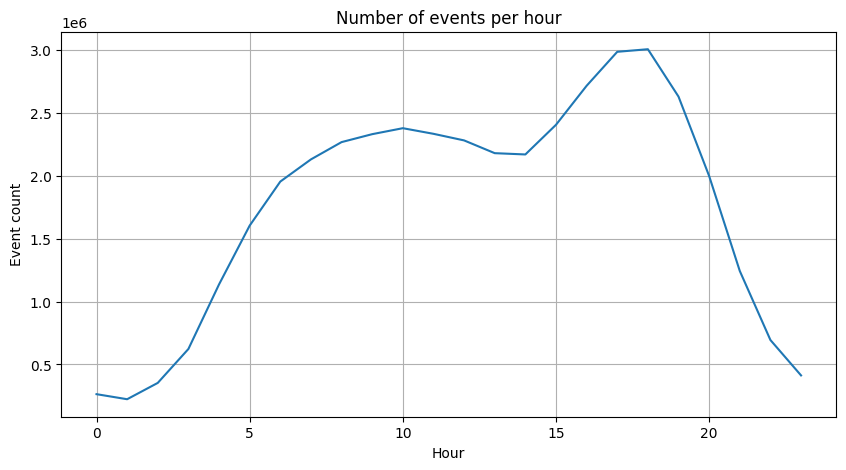

Wall time: 6.462 s
RSS Δ: +29.66 MB
Peak memory Δ: +31.50 MB (OS-dependent)


<ExecutionResult object at 791b0a307430, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 791b0a3057e0, raw_cell="# codecell_36c (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [22]:
%%timemem
# codecell_36c (keep this id for tracking purposes)

import matplotlib.pyplot as plt

events_by_hour_pdf = events_by_hour_df.toPandas()

# TODO: Write your code below, but do not remove any lines already in this cell.

plt.figure(figsize=(10, 5))
plt.plot(
    events_by_hour_pdf["hour"],
    events_by_hour_pdf["event_count"]
)
plt.xlabel("Hour")
plt.ylabel("Event count")
plt.title("Number of events per hour")
plt.grid(True)


plt.show()

### 3.7 Q7

We are going to analyze the "big" brands. Find out the average purchase price by brand, and restrict to cases where the average is more than 10K.
We want the results sorted by the average purchase price from the largest to smallest value.
(Report answers to two digits after the decimal point, i.e., XX.XX, but it's okay if the output only contains one digit after the decimal point.)

First, do it using SQL:

In [23]:
%%timemem
# codecell_37a (keep this id for tracking purposes)

# Write your SQL below

sql_query = f""" 

SELECT
    b.brand_code,
    ROUND(AVG(e.price), 2) AS avg_purchase_price
FROM events e
JOIN products p
    ON e.product_key = p.product_key
JOIN brands b
    ON p.brand_key = b.brand_key
WHERE e.event_type = 'purchase'
GROUP BY b.brand_code
HAVING AVG(e.price) > 10000
ORDER BY avg_purchase_price DESC


"""


results = spark.sql(sql_query)

results.show()

[Stage 88:=============================================>          (17 + 4) / 21]

+----------+------------------+
|brand_code|avg_purchase_price|
+----------+------------------+
|      adam|           58946.0|
|      kona|           43759.0|
|  yuandong|           35329.0|
|   bentley|           23164.0|
|      otex|          18633.14|
|    suunto|          10732.82|
|     stark|          10400.25|
+----------+------------------+

Wall time: 6.435 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 791b2ff99db0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 791b2ff98e20, raw_cell="# codecell_37a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

Next, do it with DataFrames:

In [24]:
%%timemem
# codecell_37b (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.

from pyspark.sql import functions as F

avg_price_by_brand_df = (
    events_df
    .filter(F.col("event_type") == "purchase")
    .join(products_df, on="product_key", how="inner")
    .join(brands_df, on="brand_key", how="inner")
    .groupBy(brands_df.brand_code)  
    .agg(F.avg("price").alias("avg_purchase_price"))
    .filter(F.col("avg_purchase_price") > 10000)
    .orderBy(F.col("avg_purchase_price").desc())
)

avg_price_by_brand_df.show()




[Stage 93:=============================================>          (17 + 4) / 21]

+----------+------------------+
|brand_code|avg_purchase_price|
+----------+------------------+
|      adam|           58946.0|
|      kona|           43759.0|
|  yuandong|           35329.0|
|   bentley|           23164.0|
|      otex|         18633.135|
|    suunto|10732.816666666668|
|     stark|         10400.246|
+----------+------------------+

Wall time: 6.431 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 791af7ab9000, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 791af7abb8e0, raw_cell="# codecell_37b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

When you run the cell above, `avg_price_by_brand_df` should be something like:

```
+----------+------------------+
|brand_code|         avg_price|
+----------+------------------+
|       ???|               ???|
        ...
|       ???|               ???|
+----------+------------------+
```

Now plot the above DataFrame using `matplotlib`.
Here we want a bar chart, with each of the brands as a bar, and the average price on the _y_ axis.

**Hint:** use the code below to get started.

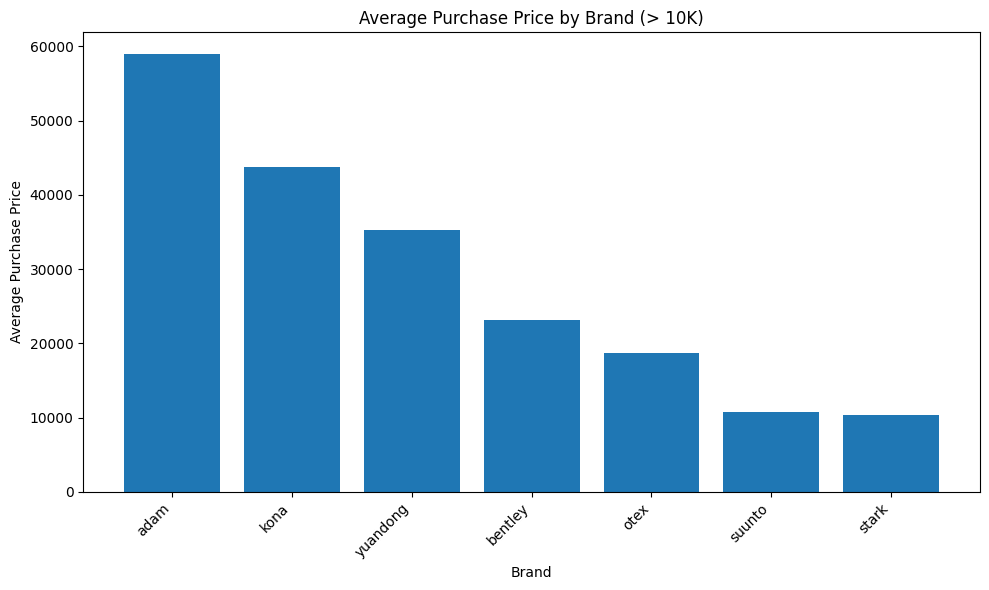

Wall time: 6.165 s
RSS Δ: +3.31 MB
Peak memory Δ: +3.66 MB (OS-dependent)


<ExecutionResult object at 791b0a305750, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 791b0a307f40, raw_cell="# codecell_37c (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [25]:
%%timemem
# codecell_37c (keep this id for tracking purposes)

import matplotlib.pyplot as plt

avg_price_by_brand_pdf = avg_price_by_brand_df.toPandas()

# TODO: Write your code below, but do not remove any lines already in this cell.

plt.figure(figsize=(10, 6))
plt.bar(
    avg_price_by_brand_pdf["brand_code"],
    avg_price_by_brand_pdf["avg_purchase_price"]
)

plt.xlabel("Brand")
plt.ylabel("Average Purchase Price")
plt.title("Average Purchase Price by Brand (> 10K)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## 4. Load RDDs

The remaining exercises focus on RDD manipulations.

Let's start by loading the RDDs.

In [26]:
# Get RDDs directly from DataFrames (with required repartitions)
# type: RDD[Row]
events_rdd   = events_df.rdd.repartition(1000)
products_rdd = products_df.rdd.repartition(100)
brands_rdd   = brands_df.rdd.repartition(100)

You'll need `Row`, so let's make sure we've imported it.

In [27]:
from pyspark.sql import Row

## 5. Implementations of Computing Averages

In this next exercise, we're going to implement "computing the mean" (version 1) and (version 3) in Spark as described in the second lecture **Batch Processing I** (please use ctrl+f to reach the slide with the title : "Computing the Mean: Version 1" or "Computing the Mean: Version 3".

To make the problem more tractable (i.e., to reduce the running times), let's first do a bit of filtering of the `events` table.
We'll do this using DataFrames, and then generate an RDD:

In [28]:
filtered_events_df = (
    events_df
        .filter((F.col("event_type") == "purchase") & F.col("price").isNotNull())
        .join(brands_df, on="brand_key")
)

filtered_events_df.count()

print(f"Number of rows in events          table: {events_df.count()}")
print(f"Number of rows in filtered events table: {filtered_events_df.count()}")

filtered_events_rdd = filtered_events_df.rdd

Number of rows in events          table: 42351862


Number of rows in filtered events table: 664885


You can confirm that we're working with a smaller dataset.

Compute the average purchase price by brand. We want the results sorted by the average purchase price from the largest to smallest value. As before, round to two digits after the decimal point. This is similar to Q7 above, except _without_ the "more than 10K" condition.

Implement using the naive **"version 1"** algorithm, as described in the lectures:

+ You _must_ start with `filtered_events_rdd`.
+ You _must_ use `groupByKey()`.
+ Per "version 1", your implementation _must_ shuffle all values from the "mappers" to the "reducers".

**write some code here**

In [29]:
%%timemem
# codecell_5x1 (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.

# (brand_code, price)
brand_price_rdd = filtered_events_rdd.map(
    lambda r: (r.brand_code, r.price)
)

# groupByKey (version naive)
grouped_rdd = brand_price_rdd.groupByKey()

# compute average
average_revenue_per_brand_v1 = (
    grouped_rdd
    .mapValues(lambda prices: round(sum(prices) / len(prices), 2))
    .sortBy(lambda x: x[1], ascending=False)
)

average_revenue_per_brand_v1.take(10)


[('adam', 58946.0),
 ('kona', 43759.0),
 ('yuandong', 35329.0),
 ('bentley', 23164.0),
 ('otex', 18633.13),
 ('suunto', 10732.82),
 ('stark', 10400.25),
 ('zenmart', 9447.0),
 ('baltekstil', 8504.19),
 ('bugati', 8288.42)]

Wall time: 14.829 s
RSS Δ: +0.50 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 791af798c640, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 791af798c070, raw_cell="# codecell_5x1 (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=[('adam', 58946.0), ('kona', 43759.0), ('yuandong', 35329.0), ('bentley', 23164.0), ('otex', 18633.13), ('suunto', 10732.82), ('stark', 10400.25), ('zenmart', 9447.0), ('baltekstil', 8504.19), ('bugati', 8288.42)]>

Compute the average purchase price by brand. We want the results sorted by the average purchase price from the largest to smallest value. As before, round to two digits after the decimal point. This is similar to Q7 above, except _without_ the "more than 10K" condition.

Implement using the improved **"version 3"** algorithm, as described in the lectures:

+ You _must_ start with `filtered_events_rdd`.
+ You _must_ use `reduceByKey()`.
+ Per "version 3", your implementation _must_ emit `(sum, count)` pairs and take advantage opportunities to perform aggregations.

**write some code here**

In [30]:
%%timemem
# codecell_5x2 (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.


# (brand_code, (sum, count))
brand_sum_count_rdd = filtered_events_rdd.map(
    lambda r: (r.brand_code, (r.price, 1))
)

# reduceByKey (local aggregation)
reduced_rdd = brand_sum_count_rdd.reduceByKey(
    lambda a, b: (a[0] + b[0], a[1] + b[1])
)


# compute average
average_revenue_per_brand_v3 = (
    reduced_rdd
    .mapValues(lambda x: round(x[0] / x[1], 2))
    .sortBy(lambda x: x[1], ascending=False)
)

average_revenue_per_brand_v3.take(10)

average_revenue_per_brand_v3.take(10)


[('adam', 58946.0),
 ('kona', 43759.0),
 ('yuandong', 35329.0),
 ('bentley', 23164.0),
 ('otex', 18633.13),
 ('suunto', 10732.82),
 ('stark', 10400.25),
 ('zenmart', 9447.0),
 ('baltekstil', 8504.19),
 ('bugati', 8288.42)]

Wall time: 14.302 s
RSS Δ: +0.12 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 791af798cf40, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 791af798dc30, raw_cell="# codecell_5x2 (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=[('adam', 58946.0), ('kona', 43759.0), ('yuandong', 35329.0), ('bentley', 23164.0), ('otex', 18633.13), ('suunto', 10732.82), ('stark', 10400.25), ('zenmart', 9447.0), ('baltekstil', 8504.19), ('bugati', 8288.42)]>

## 6. Implementations of Joins

Next, we're going to implement joins.

Our join implementations will be general, but we're going to check correctness using the following query:

In [31]:
spark.sql("""

SELECT * FROM brands b
JOIN products p ON p.brand_key = b.brand_key
WHERE b.brand_key = '423'

""").show()

+----------+--------------------+---------+-------------+----------+----------+------------+--------------------+---------+------------+-----------+
|brand_code|          brand_desc|brand_key|category_code|brand_code|product_id|product_name|        product_desc|brand_key|category_key|product_key|
+----------+--------------------+---------+-------------+----------+----------+------------+--------------------+---------+------------+-----------+
| blaupunkt|"Blaupunkt is a G...|      423|  electronics| blaupunkt|   1802099|    video.tv|The video.tv is a...|      423|           8|       4813|
| blaupunkt|"Blaupunkt is a G...|      423|  electronics| blaupunkt|   1802107|    video.tv|The video.tv is a...|      423|           8|       4821|
+----------+--------------------+---------+-------------+----------+----------+------------+--------------------+---------+------------+-----------+



### 6.1 Shuffle Join Implementation

Here, we're going to implement a shuffle join, aka reduce-side join.

Write the function `shuffle_join`, as follows:
+ Takes in `R`, `S`, `keyR`, and `keyS`: `R` and `S` are the RDDs to be joined; `keyR` and `keyS` are the join keys in `R` and `S`, respectively (type string).
+ The output is an RDD of `Row`s that corresponds to the inner join on the keys.

The function should implement a shuffle join between the two RDDs (as discussed in lecture).
Specifically:
+ You _cannot_ use the `join` (or any related) transformation on RDDs, because that would defeat the point of the exercise.
+ If you have any additional questions about allowed or disallowed transformations, ask!

Note that in SQL, `keyR` and `keyS` are repeated in the joined output (i.e., you get duplicate columns).
Here, you just want one copy.
Hint: Concatenate the `Row`s but keep only one copy of the join key.

**write some code here**

In [32]:
# codecell_61a (keep this id for tracking purposes)

# codecell_61a (keep this id for tracking purposes)

from pyspark.sql import Row

def shuffle_join(R, S, keyR, keyS):
 
    # (join_key, ("R", row))
    R_kv = R.map(lambda r: (r[keyR], ("R", r)))
    # (join_key, ("S", row))
    S_kv = S.map(lambda s: (s[keyS], ("S", s)))

    grouped = R_kv.union(S_kv).groupByKey()

    def build_rows(k_vals):
        k, vals = k_vals
        r_rows = []
        s_rows = []
        for tag, row in vals:
            if tag == "R":
                r_rows.append(row)
            else:
                s_rows.append(row)

        out = []
        # INNER JOIN = toutes combinaisons (r,s) si les deux existent
        for rr in r_rows:
            for ss in s_rows:
                rr_dict = rr.asDict(recursive=True)
                ss_dict = ss.asDict(recursive=True)

                merged = {keyR: k}

                # prefix pour éviter collisions (ex: brand_code existe dans les deux)
                merged.update({f"r_{col}": val for col, val in rr_dict.items()})
                merged.update({f"s_{col}": val for col, val in ss_dict.items()})

                out.append(Row(**merged))
        return out

    return grouped.flatMap(build_rows)





Let's try to use it!

In [33]:
%%timemem

shuffle_join_rdd = shuffle_join(brands_rdd, products_rdd, "brand_key", "brand_key")
shuffle_join_rdd.count()

115584

Wall time: 27.879 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 791af7a59390, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 791af7a5b2e0, raw_cell="
shuffle_join_rdd = shuffle_join(brands_rdd, produ.." store_history=False silent=False shell_futures=True cell_id=None> result=115584>

Add in the `WHERE` clause:

In [34]:
shuffle_join_results_rdd = shuffle_join_rdd.filter(lambda row: row["brand_key"] == 423)
shuffle_join_results_rdd.count()

2

If you look at the results, they're a bit difficult to read... why don't we just use Spark DataFrames for prettification?

In [35]:
df = spark.createDataFrame(shuffle_join_results_rdd.collect())
df.show()

+---------+------------+--------------------+-----------+---------------+------------+------------+--------------+--------------------+-----------+--------------+-------------+
|brand_key|r_brand_code|        r_brand_desc|r_brand_key|s_category_code|s_brand_code|s_product_id|s_product_name|      s_product_desc|s_brand_key|s_category_key|s_product_key|
+---------+------------+--------------------+-----------+---------------+------------+------------+--------------+--------------------+-----------+--------------+-------------+
|      423|   blaupunkt|"Blaupunkt is a G...|        423|    electronics|   blaupunkt|     1802099|      video.tv|The video.tv is a...|        423|             8|         4813|
|      423|   blaupunkt|"Blaupunkt is a G...|        423|    electronics|   blaupunkt|     1802107|      video.tv|The video.tv is a...|        423|             8|         4821|
+---------+------------+--------------------+-----------+---------------+------------+------------+--------------+-

Verify output against the SQL query.

### 6.2 Replicated Hash Join Implementation

Here, we're going to implement a replicated hash join.

Write the function `replicated_hash_join`, as follows:
+ Takes in `R`, `S`, `keyR`, and `keyS`: `R` and `S` are the RDDs to be joined; `keyR` and `keyS` are the join keys in `R` and `S`, respectively (type string).
+ The output is an RDD of `Row`s that corresponds to the inner join on the keys.

The function should implement a hash join between the two RDDs (as discussed in lecture).
Specifically:
+ `R` is the dataset you load into memory and replicate.
+ You _cannot_ use the `join` (or any related) transformation on RDDs, because that would defeat the point of the exercise.
+ If you have any additional questions about allowed or disallowed transformations, ask!

Note that in SQL, `keyR` and `keyS` are repeated in the joined output (i.e., you get duplicate columns).
Here, you just want one copy.
Hint: Concatenate the `Row`s but keep only one copy of the join key.

**write some code here**

In [36]:
# codecell_62a (keep this id for tracking purposes)


from pyspark.sql import Row
from collections import defaultdict

def replicated_hash_join(R, S, keyR, keyS):

    # 1) Build hash map on the driver from R (small)
    r_map = defaultdict(list)
    for r in R.collect():
        r_map[r[keyR]].append(r.asDict(recursive=True))

    # 2) Broadcast the hash map
    bc_r_map = R.context.broadcast(dict(r_map))

    # 3) Stream S and join using the broadcast map
    def join_one(s):
        k = s[keyS]
        matches = bc_r_map.value.get(k, [])
        if not matches:
            return []  # inner join: no match => nothing

        s_dict = s.asDict(recursive=True)
        out = []
        for r_dict in matches:
            merged = {keyR: k}
            merged.update({f"r_{col}": val for col, val in r_dict.items()})
            merged.update({f"s_{col}": val for col, val in s_dict.items()})
            out.append(Row(**merged))
        return out

    return S.flatMap(join_one)




Let's try to use it!

In [37]:
%%timemem

replicated_hash_join_rdd = replicated_hash_join(brands_rdd, products_rdd, "brand_key", "brand_key")
replicated_hash_join_rdd.count()

115584

Wall time: 3.778 s
RSS Δ: +5.00 MB
Peak memory Δ: +3.56 MB (OS-dependent)


<ExecutionResult object at 791b0a307fa0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 791b0a305e70, raw_cell="
replicated_hash_join_rdd = replicated_hash_join(b.." store_history=False silent=False shell_futures=True cell_id=None> result=115584>

Add in the `WHERE` clause:

In [38]:
replicated_hash_join_results_rdd = replicated_hash_join_rdd.filter(lambda row: row["brand_key"] == 423)
replicated_hash_join_results_rdd.count()

2

If you look at the results, they're a bit difficult to read... why don't we just use Spark DataFrames for prettification?

In [39]:
df = spark.createDataFrame(replicated_hash_join_results_rdd.collect())
df.show()

+---------+------------+--------------------+-----------+---------------+------------+------------+--------------+--------------------+-----------+--------------+-------------+
|brand_key|r_brand_code|        r_brand_desc|r_brand_key|s_category_code|s_brand_code|s_product_id|s_product_name|      s_product_desc|s_brand_key|s_category_key|s_product_key|
+---------+------------+--------------------+-----------+---------------+------------+------------+--------------+--------------------+-----------+--------------+-------------+
|      423|   blaupunkt|"Blaupunkt is a G...|        423|    electronics|   blaupunkt|     1802099|      video.tv|The video.tv is a...|        423|             8|         4813|
|      423|   blaupunkt|"Blaupunkt is a G...|        423|    electronics|   blaupunkt|     1802107|      video.tv|The video.tv is a...|        423|             8|         4821|
+---------+------------+--------------------+-----------+---------------+------------+------------+--------------+-

Verify output against the SQL query.

## 7. Join Performance

Now that we have two different implementations of joins, let's compare them, on the _same exact query_.
The first two are repeated from above.

Let's call this J1 below.
(Run the cell, it should just work. If it doesn't you'll need to fix the implementation above.)

In [40]:
%%timemem

shuffle_join_rdd = shuffle_join(brands_rdd, products_rdd, "brand_key", "brand_key").filter(lambda row: row["brand_key"] == 423)
shuffle_join_rdd.count()

2

Wall time: 13.981 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 791af7ce9870, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 791af7ce99c0, raw_cell="
shuffle_join_rdd = shuffle_join(brands_rdd, produ.." store_history=False silent=False shell_futures=True cell_id=None> result=2>

Let's call this J2 below.
(Run the cell, it should just work. If it doesn't you'll need to fix the implementation above.)

In [41]:
%%timemem

replicated_hash_join_rdd = replicated_hash_join(brands_rdd, products_rdd, "brand_key", "brand_key").filter(lambda row: row["brand_key"] == 423)
replicated_hash_join_rdd.count()

2

Wall time: 2.462 s
RSS Δ: -3.70 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 791af764ffa0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 791af764c430, raw_cell="
replicated_hash_join_rdd = replicated_hash_join(b.." store_history=False silent=False shell_futures=True cell_id=None> result=2>

Let's call this J3 below.
(Run the cell, it should just work. If it doesn't you'll need to fix the implementation above.)

In [42]:
%%timemem

replicated_hash_join_rdd = replicated_hash_join(products_rdd, brands_rdd, "brand_key", "brand_key").filter(lambda row: row["brand_key"] == 423)
replicated_hash_join_rdd.count()

2

Wall time: 9.520 s
RSS Δ: -31.62 MB
Peak memory Δ: +237.86 MB (OS-dependent)


<ExecutionResult object at 791af79d0610, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 791af79d2b00, raw_cell="
replicated_hash_join_rdd = replicated_hash_join(p.." store_history=False silent=False shell_futures=True cell_id=None> result=2>

J1, J2, and J3 should give you exactly the same results.
After all, they're just different implementations of the same query.

Answer the questions below.

**Put your answers below!**

// qcell_7x1290 (keep this id for tracking purposes)

**What are the running times of J1, J2, and J3**?
(You might want to run the cells a few times and take the average.)

- **Running time of J1:** <font color="red">13.98</font> seconds
- **Running time of J2:** <font color="red">2.46</font> seconds
- **Running time of J3:** <font color="red">9.52</font> seconds



**Explain:**

+ If the running times are what you expect, explain why X > Y > Z.
+ If the running times are _not_ what you expect, explain what they _should_ be, and then explain why X > Y > Z.
+ Specifically compare J2 and J3.

**Your answer?**

# 8. Submission

Details about the Submission of this assignment are outlined in the helper.

In [43]:
%%timemem
spark.stop()

Wall time: 2.014 s
RSS Δ: +0.25 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 791af75081c0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 791af75088b0, raw_cell="spark.stop()
" store_history=False silent=False shell_futures=True cell_id=None> result=None>

## Performance notes
- Set and justify `spark.sql.shuffle.partitions` for local vs. cluster runs.
- Prefer DataFrame built-ins over Python UDFs; push logic to Catalyst when possible.
- Use **AQE** (adaptive query execution) to mitigate skew; consider salting for extreme keys.
- Cache only when reuse exists; unpersist when no longer needed.
- Use **broadcast join** only when the small side fits in memory; verify with `explain`.
- Capture `df.explain(mode='formatted')` for at least one analysis query and one join.
- A3 note: Python RDDs cross the Python/JVM boundary; slower runtimes are expected for the RDD parts.

## Self-check (toy data)

In [49]:


if spark is not None:
    sc = spark.sparkContext

    # -------------------------------
    # Toy data
    # -------------------------------
    a = sc.parallelize([1, 2, 3, 4])   # for mean
    left = sc.parallelize([(1, 'A'), (2, 'B'), (3, 'C')])
    right = sc.parallelize([(1, 10), (2, 20)])

    # -------------------------------
    # Mean – version 1 (groupByKey)
    # -------------------------------
    def rdd_mean_v1(rdd):
        pairs = rdd.map(lambda x: ("key", x))
        grouped = pairs.groupByKey()
        return grouped.mapValues(lambda vals: sum(vals) / len(vals))

    print("Mean v1:", rdd_mean_v1(a).collect())

    # -------------------------------
    # Mean – version 3 (reduceByKey)
    # -------------------------------
    def rdd_mean_v3(rdd):
        pairs = rdd.map(lambda x: ("key", (x, 1)))
        reduced = pairs.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
        return reduced.mapValues(lambda x: x[0] / x[1])

    print("Mean v3:", rdd_mean_v3(a).collect())

    # -------------------------------
    # Shuffle join
    # -------------------------------
    def shuffle_join(R, S):
        R_kv = R.map(lambda x: (x[0], ("R", x[1])))
        S_kv = S.map(lambda x: (x[0], ("S", x[1])))

        return (
            R_kv.union(S_kv)
            .groupByKey()
            .flatMap(
                lambda x: [
                    (x[0], r[1], s[1])
                    for r in x[1] if r[0] == "R"
                    for s in x[1] if s[0] == "S"
                ]
            )
        )

    print("Shuffle join:", shuffle_join(left, right).collect())

    # -------------------------------
    # Replicated hash join
    # -------------------------------
    def replicated_hash_join(R, S):
        S_map = dict(S.collect())
        return R.filter(lambda x: x[0] in S_map) \
                .map(lambda x: (x[0], x[1], S_map[x[0]]))

    print("Replicated hash join:", replicated_hash_join(left, right).collect())


Mean v1: [('key', 2.5)]
Mean v3: [('key', 2.5)]


Shuffle join: [(1, 'A', 10), (2, 'B', 20)]
Replicated hash join: [(1, 'A', 10), (2, 'B', 20)]


## Reproducibility checklist
- Record Python, Java, and Spark versions.
- Fix timezone to UTC and log run timestamp.
- Pin random seeds where randomness is used.
- Save configs: `spark.sql.shuffle.partitions`, AQE flags, broadcast thresholds if changed.
- Provide exact run commands and input/output paths.
- Export a minimal environment file (`environment.yml` or `requirements.txt`).
- Keep data paths relative to project root; avoid user-specific absolute paths.
- Include small sample outputs for verification.
